In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import norm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv


In [2]:
orders_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
products_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
order_items_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
customer_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
order_payments_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
sellers_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
geolocation_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
order_reviews_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
product_category_translation_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')

In [3]:
#Product Categories
product_df = pd.merge(products_df, product_category_translation_df, on='product_category_name')

In [4]:
print(product_df.shape)

(32328, 10)


## Create Master df

In [5]:
# Put together the master_df to analyze.

#Join Sellers with Order Items
master_df = pd.merge(order_items_df, sellers_df, on='seller_id')
print(master_df.shape)

#Join with Olist Orders
master_df = pd.merge(master_df, orders_df, on='order_id')
print(master_df.shape)

#Join with Products
master_df = pd.merge(master_df, product_df, on='product_id')
print(master_df.shape)

#Join with Payments
master_df = pd.merge(master_df, order_payments_df, on='order_id')
print(master_df.shape)

#Join with Reviews
master_df = pd.merge(master_df, order_reviews_df, on='order_id')
print(master_df.shape)

#Join with Customers
master_df = pd.merge(master_df, customer_df, on='customer_id')
print(master_df.shape)

#Don't join the Geolocation df given that it is not as relevant to this analysis

(112650, 10)
(112650, 17)
(111023, 26)
(115878, 30)
(116581, 36)
(116581, 40)


### Date formating

In [6]:
master_df['DATE']= pd.to_datetime(master_df['order_purchase_timestamp'])
print(master_df.shape)
master_df['YEAR'] = master_df['DATE'].dt.year
print(master_df.shape)
master_df['MONTH'] = master_df['DATE'].dt.month
print(master_df.shape)

(116581, 41)
(116581, 42)
(116581, 43)


# Why Are Retailers Churning?
There are some major questions that I pose myself after briefly analyzing the data and thinking about why retailers could be churning.

## 1. Who is churning?
Is there a specific target user that is churning? Is this a major trend or are we struggling within a specific category that is heavily affecting our bottom-line? Some specific categories might be:
* Regions
* Product Category
* Seasonality?

## 2. Market Problem
* Have those retailers churned because end-user have moved somewhere else?

## 3. Product Problem
Is the product not delivering high enough-value to retailers?
* Are retailers churning because there is a better product offering? A competitor?

## 4. Operations Problem
Are we offering a mediocre service?
* Are we having problems with logistical partners?
* Are we having problems with payment platforms and processes?


The first straightforward assumption for why retailers might have churned is because their users have churned. So let's explore users behavior in terms of:

1. Number of Transactions (Orders)
2. Sales
3. Number of Customers
4. Recurring Customers  

### 1. Number of Transactions (Orders)

In [7]:
transactions_df = master_df
#transactions_df.head(3)
print(transactions_df.shape)

(116581, 43)


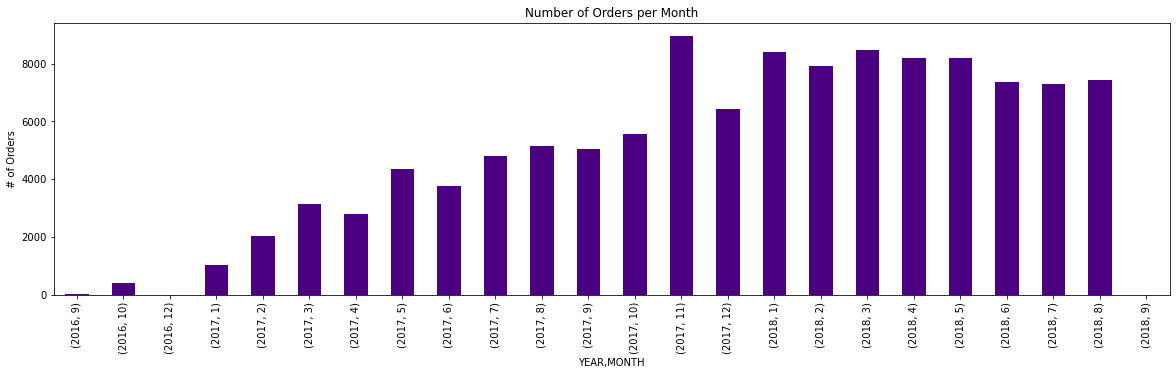

In [8]:
trans_by_date_df = transactions_df.groupby([transactions_df['YEAR'], transactions_df['MONTH']])
trans_plot_table_df = trans_by_date_df['order_id'].count()

#Plot

plt.figure(figsize=(20,5))
ax = trans_plot_table_df.plot(kind='bar', color='indigo')
ax.set_alpha(0.8)
plt.title('Number of Orders per Month')
plt.ylabel('# of Orders')

plt.show()

It seems that number of orders has been growing steadily with an exception for last few months in 2018

In [9]:
trans_plot_table_df

YEAR  MONTH
2016  9           3
      10        384
      12          1
2017  1        1010
      2        2014
      3        3134
      4        2783
      5        4341
      6        3756
      7        4811
      8        5143
      9        5055
      10       5542
      11       8963
      12       6442
2018  1        8382
      2        7898
      3        8453
      4        8194
      5        8176
      6        7372
      7        7297
      8        7426
      9           1
Name: order_id, dtype: int64

### Sales

In [10]:
sales_df = master_df
#sales_df.head(3)
print(sales_df.shape)

(116581, 43)


In [11]:
#Drop duplicates in order to get the total $ money paid in every transaction and not 'double-dipping'
sales_unique_df = sales_df.drop_duplicates(subset='order_id', keep='first')
print(sales_unique_df.shape)

(97255, 43)


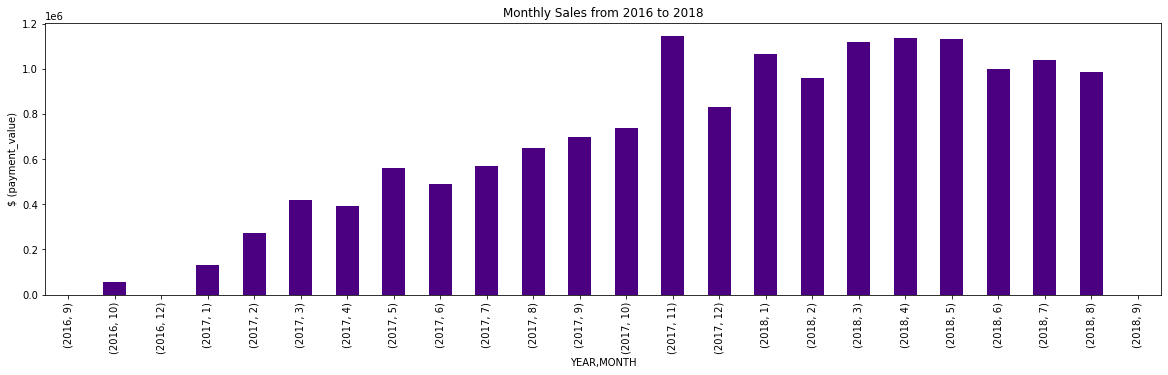

In [12]:
sales_by_date_df = sales_unique_df.groupby([sales_unique_df['YEAR'], sales_unique_df['MONTH']])
sales_plot_df = sales_by_date_df['payment_value'].sum()

plt.figure(figsize=(20,5))
ax = sales_plot_df.plot(kind='bar', color='indigo')
ax.set_alpha(0.8)
plt.title('Monthly Sales from 2016 to 2018')
plt.ylabel('$ (payment_value)')

plt.show()

### 3. Customers

In [13]:
customer_df = master_df
customer_df.head(3)
print(customer_df.shape)

(116581, 43)


In [14]:
customer_df['customer_unique_id'].nunique()

94087

In [15]:
customer_by_date_df = customer_df.groupby([customer_df['YEAR'], customer_df['MONTH']])
customer_plot_table_df = customer_by_date_df['customer_unique_id'].nunique()
customer_plot_table_df

YEAR  MONTH
2016  9           2
      10        303
      12          1
2017  1         745
      2        1659
      3        2552
      4        2296
      5        3506
      6        3099
      7        3846
      8        4148
      9        4112
      10       4446
      11       7239
      12       5424
2018  1        6941
      2        6432
      3        6979
      4        6809
      5        6759
      6        6100
      7        6164
      8        6377
      9           1
Name: customer_unique_id, dtype: int64

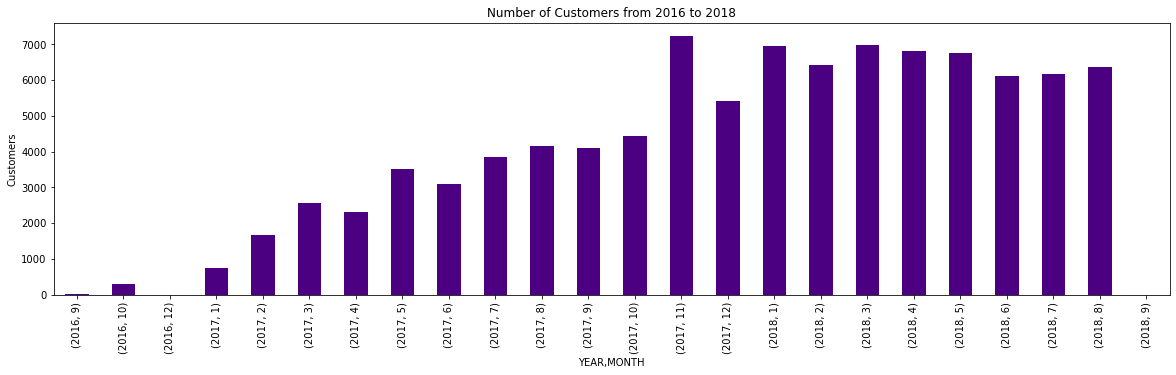

In [16]:
plt.figure(figsize=(20,5))
ax = customer_plot_table_df.plot(kind='bar', color='indigo')
ax.set_alpha(0.8)
plt.title('Number of Customers from 2016 to 2018')
plt.ylabel('Customers')

plt.show()

There is clearly a trend in which growth has stagnated during 2018 in comparison with 2017.

Is this a phenomenon in the entire Brazilian ecommerce market or is it a localized phenomenon that affects the totals? There are 2 options I am playing with right now:

1. Specific Regions
2. Specific Product Categories

## Customer coming back

In [17]:
orders_per_customers = customer_df

In [18]:
orders_per_customers['counts'] = orders_per_customers.groupby('customer_id')['order_id'].transform('count')

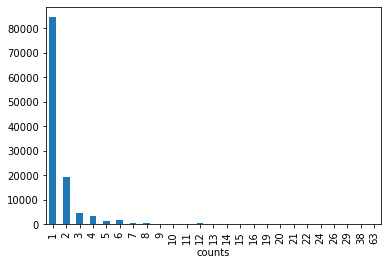

In [19]:
orders_per_customers.groupby('counts')['customer_id'].count().plot(kind='bar')

In [20]:
orders_per_customers.groupby('counts')['customer_id'].count()

counts
1     84526
2     19374
3      4581
4      3264
5      1210
6      1680
7       322
8       312
9       108
10      150
11      121
12      240
13       39
14       70
15       90
16       32
19       19
20       60
21       63
22       44
24      120
26       26
29       29
38       38
63       63
Name: customer_id, dtype: int64

-> The vast majority of customers just buy 1 time on Olist, few buy 2 or 3 times. Returning customers are very rare.

-> This could signal a problem in terms of buying experience or quality

## Customer Satisfaction

In [21]:
customer_df['review_score'].dtype

dtype('int64')

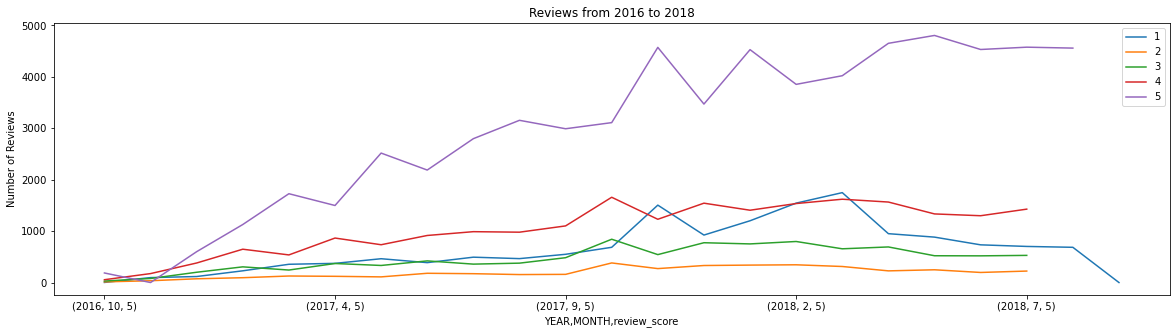

In [22]:
# Per review_score
review_score_list = [1, 2, 3, 4, 5]

plt.figure(figsize=(20,5))

for review in review_score_list:
    review_score_df = customer_df[customer_df['review_score']==review]
    review_score_per_month_df = review_score_df.groupby([review_score_df['YEAR'], review_score_df['MONTH'], review_score_df['review_score']])
    top6_to_plot = review_score_per_month_df['review_score'].count()
    #plot
    ax = top6_to_plot.plot(label=review)
    
#plot
ax.legend()
ax.set_alpha(0.8)
plt.title('Reviews from 2016 to 2018')
plt.ylabel('Number of Reviews')
plt.show()

### By Region
Let's take into consideration customer state.

In [23]:
#What are the top regions that have more customers??
customer_state_df = customer_df.groupby(customer_df['customer_state'])
customer_state_df['customer_unique_id'].count().sort_values(ascending=False).head(5)

customer_state
SP    49133
RJ    15185
MG    13530
RS     6436
PR     5908
Name: customer_unique_id, dtype: int64

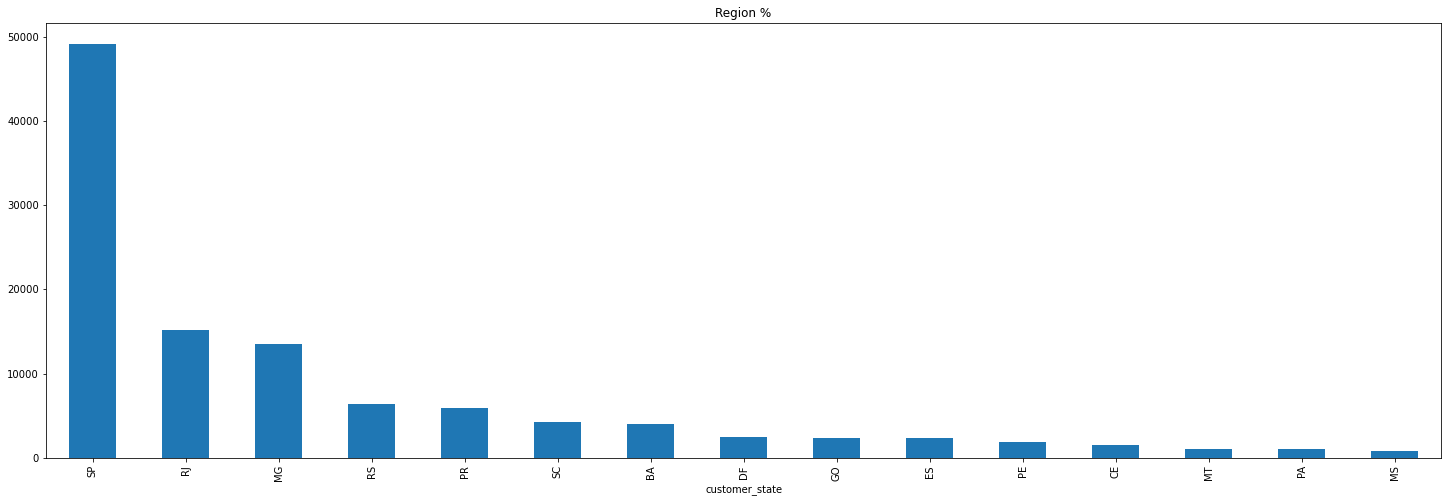

In [24]:

plt.figure(figsize=(25,8))
pie_chart_state = customer_state_df['customer_unique_id'].count().sort_values(ascending=False).head(15)

#Plot
ax = pie_chart_state.plot(kind='bar')
ax.set_alpha(0.8)
plt.title('Region %')

plt.show()

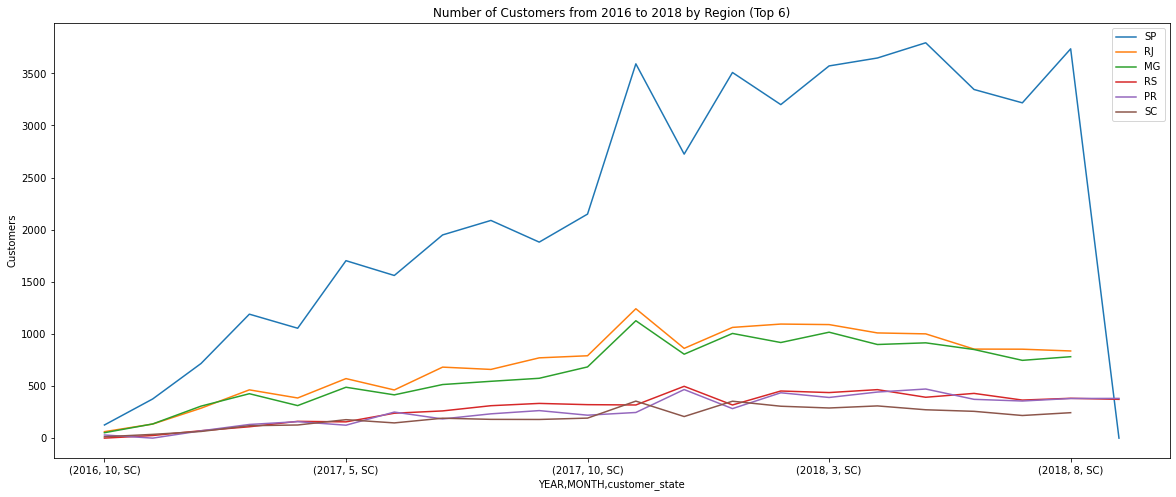

In [25]:
# Filter just for the top 6 regions
top_6_list = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC']

plt.figure(figsize=(20,8))

for state in top_6_list:
    customer_state_df_top = customer_df[customer_df['customer_state']==state]
    customer_state_top6_df = customer_state_df_top.groupby([customer_state_df_top['YEAR'], customer_state_df_top['MONTH'], customer_state_df_top['customer_state']])
    top6_to_plot = customer_state_top6_df['customer_unique_id'].count()
    #plot
    ax = top6_to_plot.plot(label=state)
    
#plot
ax.legend()
ax.set_alpha(0.8)
plt.title('Number of Customers from 2016 to 2018 by Region (Top 6)')
plt.ylabel('Customers')
plt.show()

It is clear that SP, possibly Sao Paulo is the greatest marketshare for Olist. But, what is the trend when we don't consider SP?

### Customers by Region (Top 5, excluded Sao Paulo)

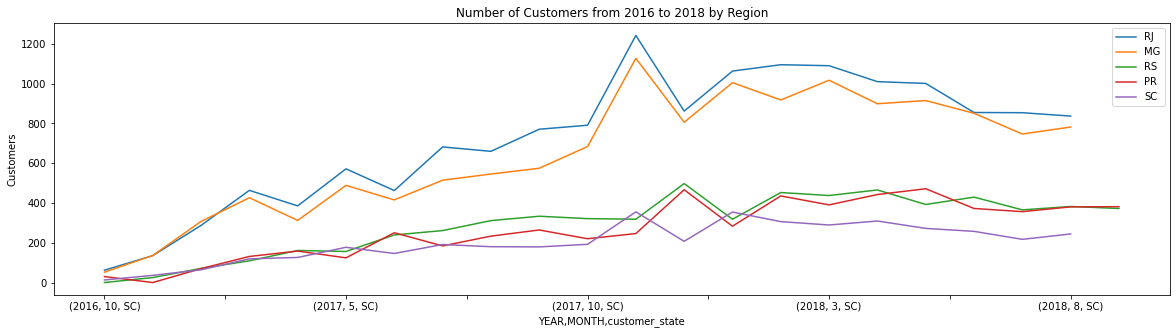

In [26]:
# Filter just for the top 5 regions
top_5_list = ['RJ', 'MG', 'RS', 'PR', 'SC']

plt.figure(figsize=(20,5))

for state in top_5_list:
    customer_state_df_top = customer_df[customer_df['customer_state']==state]
    customer_state_top5_df = customer_state_df_top.groupby([customer_state_df_top['YEAR'], customer_state_df_top['MONTH'], customer_state_df_top['customer_state']])
    top5_to_plot = customer_state_top5_df['customer_unique_id'].count()
    #plot
    ax = top5_to_plot.plot(label=state)
    
#plot
ax.legend()
ax.set_alpha(0.8)
plt.title('Number of Customers from 2016 to 2018 by Region')
plt.ylabel('Customers')
plt.show()

### Notes:

-> SP is still really strong but it doesn't have a strong growing trend either.

-> Most states share similar decreasing trend since 2017. So, it isn't something that happened in one particular state meaning operations per location might be fine.

-> Seasonality doesn't seem to be a major problem. 2018 has been a 'flat' year for Olist. In 2017, it grew the whole year.

-> Something might have happened at the end of 2017 that shifted the ecommerce market. Some ideas:

1. A new competitor in the market could be taking clients away.
2. It is mentioned that there is no major bug. But, the product might not seem so appealing to clients and that's why end-users are churning and consequently retailers could churn.



## Per Product Category

In [27]:
product_category_df = master_df
#product_category_df.head(3)
print(product_category_df.shape)

(116581, 44)


In [28]:
product_category_df['product_category_name_english'].nunique()

71

In [29]:
#What are the top product categories that have more customers??
category_df = product_category_df.groupby(product_category_df['product_category_name_english'])
category_df['payment_value'].sum().sort_values(ascending=False).head(10)

product_category_name_english
bed_bath_table           1744205.53
health_beauty            1663076.30
computers_accessories    1599574.66
furniture_decor          1444383.69
watches_gifts            1430553.48
sports_leisure           1400270.11
housewares               1097900.09
auto                      855095.68
garden_tools              840721.59
cool_stuff                781933.97
Name: payment_value, dtype: float64

In [30]:
category_df['customer_unique_id'].count().sort_values(ascending=False).head(10)

product_category_name_english
bed_bath_table           11990
health_beauty            10030
sports_leisure            9005
furniture_decor           8833
computers_accessories     8151
housewares                7380
watches_gifts             6213
telephony                 4726
garden_tools              4590
auto                      4400
Name: customer_unique_id, dtype: int64

-> Interesting to note that there are some categories that are more impactful to revenue even if they have less number of clients. For instance, 'computer_accesories'.

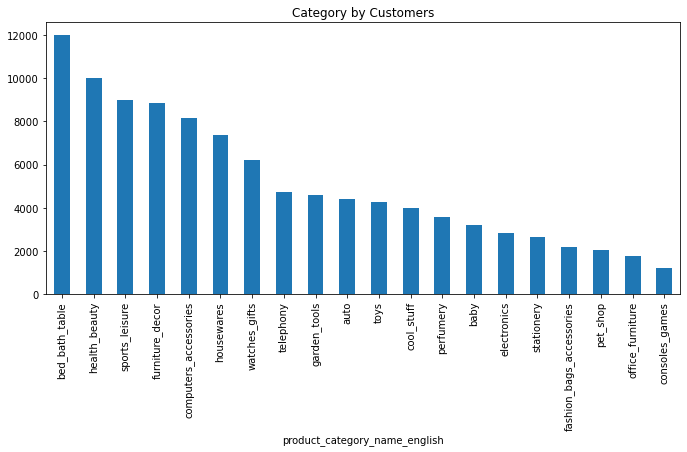

In [31]:
pie_chart_product = category_df['customer_unique_id'].count().sort_values(ascending=False).head(20)

#Plot
plt.figure(figsize=(25,5))

plt.subplot(1,2,1)
ax = pie_chart_product.plot(kind='bar')
ax.set_alpha(0.8)
plt.title('Category by Customers')
plt.show()

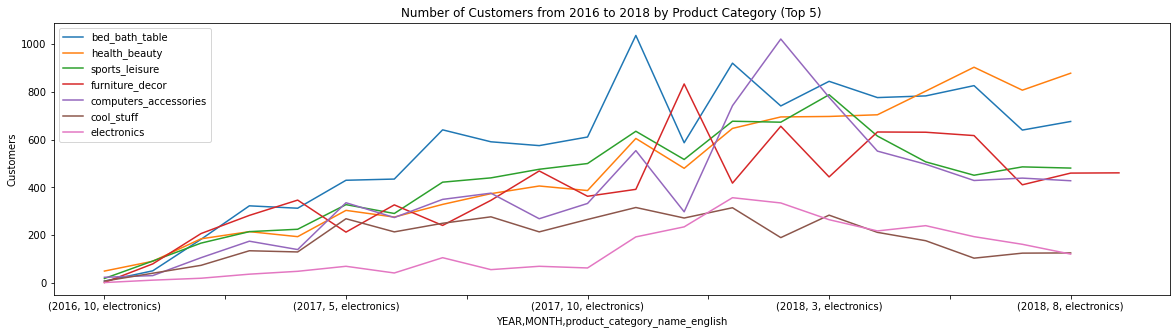

In [32]:
# Filter just for the top 5 regions
top5_cat_customer = ['bed_bath_table', 'health_beauty','sports_leisure','furniture_decor','computers_accessories', 'cool_stuff', 'electronics']

plt.figure(figsize=(20,5))

for state in top5_cat_customer:
    cat_customer_top_df = product_category_df[product_category_df['product_category_name_english']==state]
    cat_cust_date_df = cat_customer_top_df.groupby([cat_customer_top_df['YEAR'], cat_customer_top_df['MONTH'], cat_customer_top_df['product_category_name_english']])
    top5_cat_cust_to_plot = cat_cust_date_df['customer_unique_id'].count()
    #plot
    ax = top5_cat_cust_to_plot.plot(label=state)
    
#plot
ax.legend()
ax.set_alpha(0.8)
plt.title('Number of Customers from 2016 to 2018 by Product Category (Top 5)')
plt.ylabel('Customers')
plt.show()

-> Interesting to notice that the 'computer_accesories' category had an abnormal decrease during 2018. Same happens for 'sports_leisure', 'cool_stuff'

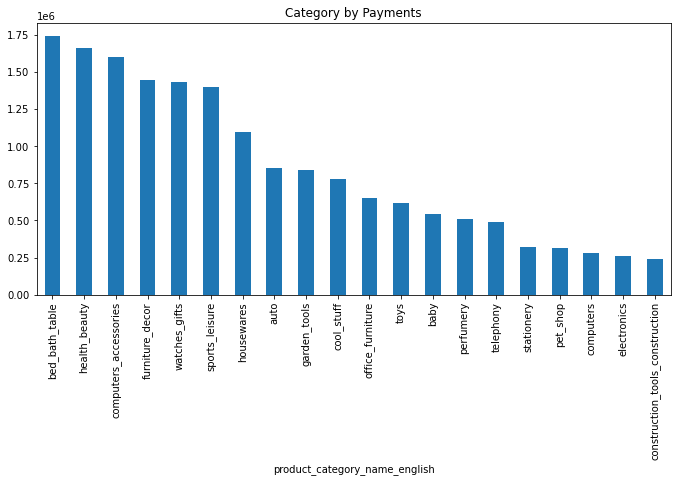

In [33]:
pie_chart_product_payment = category_df['payment_value'].sum().sort_values(ascending=False).head(20)

#Plot
plt.figure(figsize=(25,5))

plt.subplot(1,2,2)
ax = pie_chart_product_payment.plot(kind='bar')
ax.set_alpha(0.8)
plt.title('Category by Payments')


plt.show()

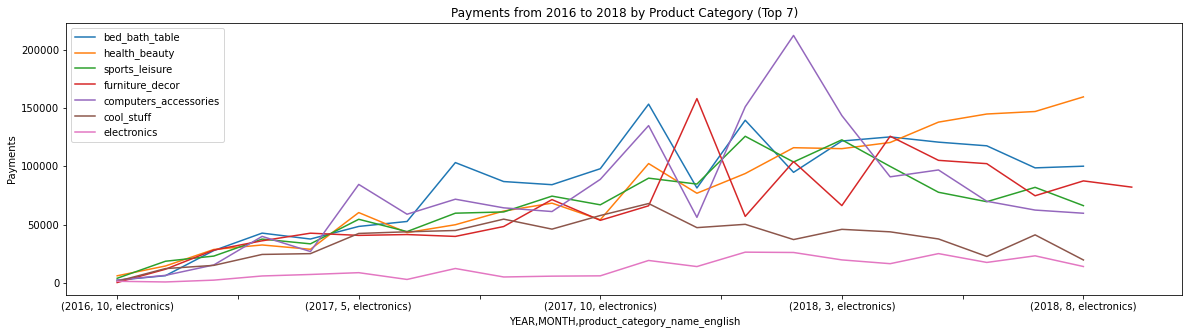

In [34]:
# Filter just for the top 7 product categories
top5_cat_payment = ['bed_bath_table', 'health_beauty','sports_leisure','furniture_decor','computers_accessories', 'cool_stuff', 'electronics']

plt.figure(figsize=(20,5))

for state in top5_cat_payment:
    cat_payment_top_df = product_category_df[product_category_df['product_category_name_english']==state]
    cat_pay_date_df = cat_payment_top_df.groupby([cat_payment_top_df['YEAR'], cat_payment_top_df['MONTH'], cat_payment_top_df['product_category_name_english']])
    top5_cat_pay_to_plot = cat_pay_date_df['payment_value'].sum()
    #plot
    ax = top5_cat_pay_to_plot.plot(label=state)
    
#plot
ax.legend()
ax.set_alpha(0.8)
plt.title('Payments from 2016 to 2018 by Product Category (Top 7)')
plt.ylabel('Payments')
plt.show()

In [35]:
top5_cat_pay_to_plot

YEAR  MONTH  product_category_name_english
2016  10     electronics                       1347.57
2017  1      electronics                        772.43
      2      electronics                       2337.81
      3      electronics                       5911.74
      4      electronics                       7198.38
      5      electronics                       8741.32
      6      electronics                       2929.16
      7      electronics                      12328.07
      8      electronics                       5048.20
      9      electronics                       5752.33
      10     electronics                       6023.42
      11     electronics                      19224.08
      12     electronics                      13997.31
2018  1      electronics                      26360.78
      2      electronics                      26079.18
      3      electronics                      19713.48
      4      electronics                      16465.48
      5      electroni

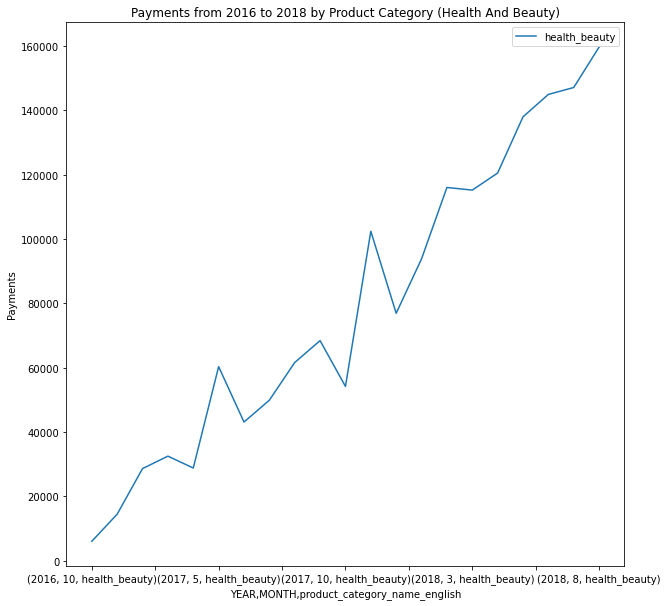

In [36]:
# Filter just for the top 7 product categories
top5_cat_payment = ['health_beauty']#,'sports_leisure','furniture_decor','computers_accessories', 'cool_stuff', 'electronics']

plt.figure(figsize=(10,10))

for state in top5_cat_payment:
    cat_payment_top_df = product_category_df[product_category_df['product_category_name_english']==state]
    cat_pay_date_df = cat_payment_top_df.groupby([cat_payment_top_df['YEAR'], cat_payment_top_df['MONTH'], cat_payment_top_df['product_category_name_english']])
    top5_cat_pay_to_plot = cat_pay_date_df['payment_value'].sum()
    #plot
    ax = top5_cat_pay_to_plot.plot(label=state)
    
#plot
ax.legend()
ax.set_alpha(0.8)
plt.title('Payments from 2016 to 2018 by Product Category (Health And Beauty)')
plt.ylabel('Payments')
plt.show()

In [37]:
#Trial export to csv
top5_cat_pay_to_plot.to_csv (r'C:\Users\sebastianyerovi\Desktop\export_dataframe.csv', index = False, header=True)

In [38]:
top5_cat_pay_to_plot

YEAR  MONTH  product_category_name_english
2016  10     health_beauty                      6062.16
2017  1      health_beauty                     14485.80
      2      health_beauty                     28661.58
      3      health_beauty                     32529.42
      4      health_beauty                     28832.28
      5      health_beauty                     60348.16
      6      health_beauty                     43134.50
      7      health_beauty                     49910.06
      8      health_beauty                     61641.03
      9      health_beauty                     68439.53
      10     health_beauty                     54199.99
      11     health_beauty                    102436.77
      12     health_beauty                     76944.70
2018  1      health_beauty                     93852.80
      2      health_beauty                    116048.58
      3      health_beauty                    115229.36
      4      health_beauty                    120530.50
     

### Notes:
-> In both the payments and number of customers analysis per top product category it is clear there is an overall declining trend. 

-> However, there is a really marked trend for the 'computer_accesories' category.

-> The health_beauty category is really spiking and it probably saved Q1,Q2, and Q3 for Olist.

-> The impact of the declining trend is stronger for the payments case. It is no good news cause revenue bottom-line will be the first one affected, even if number of customers just seem flattening.  

What this could mean is:

1. A major competitor or competitors entered the market. Those competitors could have a deep specialization of computer_accesories and tech-related products.
2. Our product is not valuable enough for retailers. But, that doesn't explain the heavy fall of computer category. 
3. A law was passed on specific product categories such as computer_accesories.


De hecho si! Amazon, comenzó a ofrecer productos electrónicos en esta época!
https://www.magmapartners.com/es/e-commerce-en-brasil-el-centro-de-comercio-electronico-de-america-latina/

## Thought Notes

Ok, so it seems that Amazon expanded in product categories in Brazil, competition got stronger (even other competitors appeared in the scene) and that's what could explain customer churn. But **why** are they churning to Amazon (and others)?


1. Is this a problem where end-user has a better customer experience by shopping on Amazon?

    a. Better shopping experience (at website)
    
    b. Cheaper prices
    
        - Payment methods (Boletas are a native-widely used form of payments in BR)
        
    c. Better Delivery
    
        * Faster Delivery
        * Return-policies?
        Addresses are an issue in BR as in most LATAM. 
    
2. Is this a problem where retailers have churned to Amazon not necessarily because end-users churned, but because Amazon offers a better product for retailers?

    a. Cheaper fees
    
    b. Reporting
    
    c. Financing Options? (Boletas lack liquidity, it is a payment that is done days after the purchase)
    https://www.reuters.com/article/us-alibaba-brazil/alibaba-may-provide-brazil-credit-services-paper-reports-idUSKBN17S1SL

## Next Steps
From the hypothesis above I will focus on:

1. Logistics Partners
    - Are we having trouble fulfulling our product with logistics partners?
    - Too slow? If so, where exactly in the chain is the problem?

2. Prices and Payments
    - What is the % of freight in total order value?


# 4. Operations Problem

In [39]:
datetime_df = master_df

In [40]:
#Convert to datetime
datetime_df['order_purchase_timestamp'] = pd.to_datetime(datetime_df['order_purchase_timestamp'])
datetime_df['order_approved_at'] = pd.to_datetime(datetime_df['order_approved_at'])
datetime_df['order_delivered_carrier_date'] = pd.to_datetime(datetime_df['order_delivered_carrier_date'])
datetime_df['order_delivered_customer_date'] = pd.to_datetime(datetime_df['order_delivered_customer_date'])
datetime_df['order_estimated_delivery_date'] = pd.to_datetime(datetime_df['order_estimated_delivery_date'])

In [41]:
#Calculate time between delivery steps
datetime_df['purchase_to_approve_hours'] = (datetime_df['order_approved_at']-datetime_df['order_purchase_timestamp'])/pd.Timedelta(hours=1) 
datetime_df['approve_to_carrier_days'] = (datetime_df['order_delivered_carrier_date']-datetime_df['order_approved_at'])/pd.Timedelta(days=1)
datetime_df['carrier_to_customer_days'] = (datetime_df['order_delivered_customer_date']-datetime_df['order_delivered_carrier_date'])/pd.Timedelta(days=1) 
datetime_df['estimated_days'] = (datetime_df['order_estimated_delivery_date']-datetime_df['order_purchase_timestamp'])/pd.Timedelta(days=1) 
datetime_df['actual_days'] = (datetime_df['order_delivered_customer_date']-datetime_df['order_purchase_timestamp'])/pd.Timedelta(days=1) 

In [42]:
#Calculate customer expectation
datetime_df['diff_est_act_delivery'] = datetime_df['actual_days']-datetime_df['estimated_days']

In [43]:
diff_mean = np.mean(datetime_df['diff_est_act_delivery'])
diff_mean

-11.360611775342509

In [44]:
estimated_delivery_mean = np.mean(datetime_df['estimated_days'])
actual_delivery_mean = np.mean(datetime_df['actual_days'])
print(estimated_delivery_mean,actual_delivery_mean)

23.874585521944155 12.48500167381971


Ok, so it is really interesting that we are actually delivering ahead of promised time on average. By 11 days? That's a lot. The delivery estimation should be really wrongly calculated. While it's usually useful to underpromise and over-deliver, it is defintely not good by such a big gap.

**We should fix our estimated delivery date, be more accurate.**

Part of end user's churn might come from that the fact that they assume our retailer's delivery just takes too long. In reality it is not even like that.

Also, Amazon offers free-returns, probably faster and more reliable shipping. 

In [45]:
purchase_to_approve_hours_mean = np.mean(datetime_df['purchase_to_approve_hours'])
approve_to_carrier_days_mean = np.mean(datetime_df['approve_to_carrier_days'])
carrier_to_customer_days_mean = np.mean(datetime_df['carrier_to_customer_days'])

print('Hours from purchase to payment approval: '+str(np.round(purchase_to_approve_hours_mean, 2))+' hours')
print('Days from approval to carrier: '+str(np.round(approve_to_carrier_days_mean, 2)))
print('Days from carrier to customer: '+str(np.round(carrier_to_customer_days_mean, 2)))

Hours from purchase to payment approval: 10.5 hours
Days from approval to carrier: 2.85
Days from carrier to customer: 9.2


-> From logistic partner tu customer is the longest time.
-> It is really interesting to me that purchase to approval takes ~10 hours

I wanna keep exploring this route of purchase to payment


### Does approval time differ with a payment type in particular? 

In [46]:
datetime_by_payment_type_df = datetime_df.groupby(datetime_df['payment_type'])
datetime_by_payment_type_df.mean()

,order_item_id,price,freight_value,seller_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,...,customer_zip_code_prefix,YEAR,MONTH,counts,purchase_to_approve_hours,approve_to_carrier_days,carrier_to_customer_days,estimated_days,actual_days,diff_est_act_delivery
payment_type,,,,,,,,,,,,,,,,,,,,,
boleto,1.252203,104.454134,19.722653,24580.583818,48.809272,790.916446,2.202142,2000.250617,29.919487,16.355500,...,37271.219725,2017.517187,6.037502,1.521858,33.254602,2.853623,9.163802,24.079339,13.399883,-10.640589
credit_card,1.187846,126.430915,20.191972,24591.784251,48.764021,786.801900,2.210854,2147.998128,30.361617,16.758019,...,34710.107404,2017.546040,6.029961,1.457971,4.642208,2.849012,9.232434,23.847635,12.267295,-11.552657
debit_card,1.155462,108.741050,18.700468,22280.300120,49.019208,829.283313,2.127851,1617.236495,28.423770,14.966387,...,30272.211285,2017.722689,6.214286,1.324730,9.387724,2.628883,7.737242,21.585451,10.748762,-10.811100
voucher,1.132346,104.862940,19.877438,23621.692642,48.573338,744.371599,2.154886,2221.311222,31.688939,16.604573,...,32986.904041,2017.467719,5.995975,5.233135,8.877084,2.897391,9.364186,24.113763,12.624587,-11.477898


-> Yep boleto payments are really though, they take ~33 hours to be approved. Boleto constitutes 19% of all payments. So it delays at least 1 day when paid by boleto. 

### Does delivery time differ in a particular state?

In [47]:
#top_6_list = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC']
datetime_by_state_type_df = datetime_df.groupby(datetime_df['customer_state'])
datetime_by_state_type_df['actual_days', 'estimated_days','purchase_to_approve_hours','approve_to_carrier_days', 'carrier_to_customer_days'].mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,actual_days,estimated_days,purchase_to_approve_hours,approve_to_carrier_days,carrier_to_customer_days
customer_state,,,,,
AC,20.544743,41.218262,13.407536,2.708634,17.254193
AL,24.575704,32.490250,12.299160,3.126106,20.930996
AM,26.445744,45.476186,8.818830,2.376634,23.698527
AP,28.109409,46.011902,17.228866,2.922049,24.468720
BA,19.221483,29.462033,11.788187,2.878132,15.847790
CE,20.706723,31.359048,11.237011,2.838918,17.426805
DF,12.954913,24.519323,10.361574,2.863349,9.684126
ES,15.678946,25.639812,10.528171,3.018869,12.213841
GO,15.250878,27.000464,12.797936,2.541443,12.193359


Nah, not really

-> It is clear why SP is so important. Also delivery dates are lower for SP when compared to every other state

## Prices and Payments

### What is the % of freight in total order value?

In [48]:
payment_structure_df = master_df
payment_structure_df['freight_over_price'] = payment_structure_df['freight_value']/payment_structure_df['price']

In [49]:
freight_over_price_mean = np.mean(payment_structure_df['freight_over_price'])
freight_over_price_mean

0.32190641130206954

In [50]:
top7_cat = ['bed_bath_table', 'health_beauty','sports_leisure','furniture_decor','computers_accessories', 'cool_stuff', 'electronics']

payment_structure_loc_df = payment_structure_df.loc[payment_structure_df['product_category_name_english'].isin(top7_cat)]

freight_over_price_by_group = payment_structure_loc_df.groupby(payment_structure_loc_df['product_category_name_english'])
freight_over_price_by_group['freight_over_price'].mean()

product_category_name_english
bed_bath_table           0.289432
computers_accessories    0.301197
cool_stuff               0.221835
electronics              0.676842
furniture_decor          0.347176
health_beauty            0.303996
sports_leisure           0.294732
Name: freight_over_price, dtype: float64

Well, transportation costs add 30% of price value to final price. It is a big cost.

-> Electronics is 67% add-up. That's a lot.